In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [2]:
random.seed(42)

## Setup

In [3]:
size_of_model = 1000

In [4]:
df = pd.DataFrame()
ID = list(range(0,size_of_model))

In [5]:
daily_contacts_mean = 15
daily_contacts = []
for i in range (size_of_model):
    daily_contacts.append(np.random.poisson(daily_contacts_mean))

In [6]:
friend_group_mean = 5
friend_group = []
for i in range (size_of_model):
    friend_group.append(np.random.poisson(friend_group_mean))

In [7]:
status = []
for i in range(size_of_model):
    status.append('S')
r = np.random.randint(1,size_of_model)
status[r] = 'I'

In [8]:
friends_list = []
for i in range(size_of_model):
    friends_list.append([])

In [9]:
days_to_next_stage = []
for i in range(size_of_model):
    days_to_next_stage.append(-1)
days_to_next_stage[r] = np.random.poisson(5)

In [10]:
def reset_df(df):
    df["ID"] = ID
    df["Friend_Group_Size"] = friend_group
    df["Friends_List"] = friends_list
    df["Daily_Contacts_Size"] = daily_contacts
    df["Status"] = status
    df["Days_To_Next_Stage"] = days_to_next_stage
    
    return df
df = reset_df(df)

## Graphing

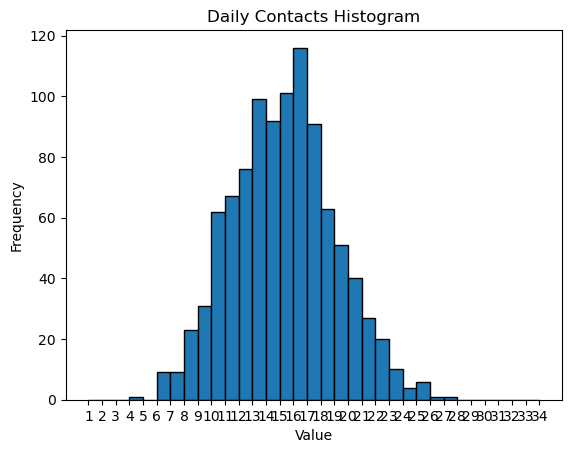

In [11]:
plt.hist(daily_contacts, bins=range(1,35), edgecolor='black')
plt.xticks(range(1,35))
plt.title('Daily Contacts Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

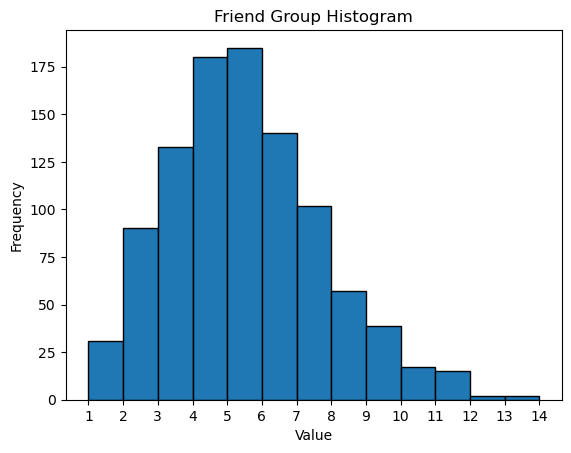

In [12]:
plt.hist(friend_group, bins=range(1,15), edgecolor='black')
plt.xticks(range(1,15))
plt.title('Friend Group Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

## Modeling

### Parameters

In [13]:
df.columns

Index(['ID', 'Friend_Group_Size', 'Friends_List', 'Daily_Contacts_Size',
       'Status', 'Days_To_Next_Stage'],
      dtype='object')

In [14]:
meets_friend_chance = 0.15 
gains_friendship_chance = 0.4
infection_chance = 0.1
latent_infectious_chance = 0.4
carrier_chance = 0.2
mean_length_of_status = {"L": 3, "LI": 2, "C": 5, "I": 5, "IS": 7, "R": 60}

Stages of Infection:
Susceptible (S)
Latent (L): No symptoms showing, noncontagious. May develop symptoms and become infectious or may be latent infectious
Latent-infections (LI): No symptoms showing, contagious. May develop symptoms and become infectious or may become a carrier
Infectious (I): symptomatic and contagious. Next stage is Recovered
Carrier (C): Asymptomatic and contagious. Next stage is Recovered
Recovered (R): recovered and has immunity. 

In [45]:
import sys
next_stage_baseline = {"L": "IS", "LI": "I", "I": "R", "IS": "R", "C": "R", "R": "S"}
next_stage_other = {"L": "LI", "LI": "C"}
infectious = ["I", "C", "LI", "IS"]
infection_rate = {"I": 0.04, "C": 0.025, "LI": 0.025, "IS": 0.04}

def remaining_friends(f_list, remaining_contacts):
    r_f = []
    for i in range (len(f_list)):
        if has_contacts_remaining(remaining_contacts, f_list[i]):
            r_f.append(i)
    return r_f

def has_contacts_remaining(remaining_contacts, index):
    if (remaining_contacts[index] > 0):
        return True
    return False

def infected(inf_type):
    if (random.random() < infection_rate.get(inf_type)):
            return True
    return False

def latent_infectious():
    if (random.random() < latent_infectious_chance):
            return True
    return False

def carrier():
    if (random.random() < carrier_chance):
            return True
    return False

def infect(interactor):
    global df
    df.loc[interactor, "Status"] = 'L'
    df.loc[interactor, "Days_To_Next_Stage"] = np.random.poisson(mean_length_of_status.get("L"))
    

def social_interaction(interactor_1, interactor_2): 
    #has a social interaction. Removes one remaining interaction from the interactors
    #Random chance to infect the other if one of them has the virus
    #Chance to add the other as a friend if both of their friend groups are open
    global df
    global remaining_contacts
    global counter
    
    #Friendship
    if (df["Friend_Group_Size"][interactor_1] > len(df["Friends_List"][interactor_1]) 
    and df["Friend_Group_Size"][interactor_2] > len(df["Friends_List"][interactor_2])
    and interactor_1 not in df["Friends_List"][interactor_2]):
        if random.random() < gains_friendship_chance:
            df["Friends_List"][interactor_1].append(interactor_2)
            df["Friends_List"][interactor_2].append(interactor_1)
    
    #Infection
    if (df["Status"][interactor_1] in infectious and df["Status"][interactor_2] 
        not in infectious and df["Status"][interactor_2] != 'R'):
        if infected(df["Status"][interactor_1]):
            infect(interactor_2)
            #print(f"{interactor_1} infected {interactor_2}")
            
    elif (df["Status"][interactor_1] not in infectious and df["Status"][interactor_2] in infectious
          and df["Status"][interactor_1] != 'R'):
        if infected(df["Status"][interactor_2]):
            infect(interactor_1)
            #print(f"{interactor_2} infected {interactor_1}")

    #Remaining contacts for the day for the interactors are decreased
    remaining_contacts[interactor_1] -= 1
    remaining_contacts[interactor_2] -= 1
    
    if has_contacts_remaining(remaining_contacts, interactor_1) == False:
            has_no_more_contacts.add(interactor_1)
    if has_contacts_remaining(remaining_contacts, interactor_2) == False:
            has_no_more_contacts.add(interactor_2)
    counter += 2
            


def random_social_interaction(next_person): #has a social interaction with a random non friend who has contacts remaining
    possible_choices = []
    for choice in df["ID"]:
        if remaining_contacts[choice] and choice != next_person and choice not in f_list:
            possible_choices.append(choice)
    social_interaction(next_person, random.choice(possible_choices))

def advance_stages():
    """ Check all people in the model. If they have some condition, decrement the Days_To_Next_Stage.
    If the Days_To_Next_Stage becomes 0, move them to the next stage
    """
    global df
    for i in range(size_of_model):
        if df.loc[i, "Days_To_Next_Stage"] > 0:
            df.loc[i, "Days_To_Next_Stage"] -= 1
            
        if df.loc[i, "Days_To_Next_Stage"] == 0:
            if df.loc[i, "Status"] == "L" and latent_infectious():
                df.loc[i, "Status"] = next_stage_other.get(df.loc[i, "Status"])
                
            elif df.loc[i, "Status"] == "LI" and carrier():
                df.loc[i, "Status"] = next_stage_other.get(df.loc[i, "Status"])
                
            else:
                df.loc[i, "Status"] = next_stage_baseline.get(df.loc[i, "Status"])
                
                
            if df.loc[i, "Status"] != "S":
                df.loc[i, "Days_To_Next_Stage"] = np.random.poisson(mean_length_of_status.get(df.loc[i, "Status"]))
                
            else:
                df.loc[i, "Days_To_Next_Stage"] = -1
            
def check_contacts(remaining_contacts, parity):
    count = 0
    for contact in remaining_contacts:
        count += contact
        if count > parity:
            return True
    return False

def day_model():
    global has_no_more_contacts
    global f_list
    global remaining_contacts
    global df
    global counter
    
    remaining_contacts = []
    for i in df["Daily_Contacts_Size"]:
        remaining_contacts.append(np.random.poisson(i))
    
    parity = sum(remaining_contacts) % 2
    has_no_more_contacts = set()
            
    current_index = 0
    counter = 0
    numbers = list(range(size_of_model))
    random.shuffle(numbers)
    while check_contacts(remaining_contacts, parity): #if the sum of the number of contacts is odd, someone won't be able to interact with everyone
        
        next_person = numbers[current_index]
        f_list = df["Friends_List"][next_person]
        if not has_contacts_remaining(remaining_contacts, next_person):
            has_no_more_contacts.add(next_person)
            current_index += 1
        else:
            friends_with_contacts_remaining = remaining_friends(f_list, remaining_contacts)
            
            if friends_with_contacts_remaining and random.random() < meets_friend_chance:
                social_interaction(next_person, random.choice(friends_with_contacts_remaining))
                
            else:
                random_social_interaction(next_person)

    advance_stages()
    

In [46]:
df = reset_df(df)

In [47]:
df["Status"].value_counts()

S    999
I      1
Name: Status, dtype: int64

In [48]:
infection_counts_df = pd.DataFrame()
infection_counts_df[0] = df["Status"]
avg_time = 0
for i in range(1,60):
    print(f"Starting Day {i}")
    start = time.time()
    day_model()
    end = time.time()
    avg_time += end - start
    infection_counts_df[i] = df["Status"]
    counter = i
avg_time /= i
print(f"The average time per day was  {avg_time}")

Starting Day 1
Starting Day 2
Starting Day 3
Starting Day 4
Starting Day 5
Starting Day 6
Starting Day 7
Starting Day 8
Starting Day 9
Starting Day 10
Starting Day 11
Starting Day 12
Starting Day 13
Starting Day 14
Starting Day 15
Starting Day 16
Starting Day 17
Starting Day 18
Starting Day 19
Starting Day 20
Starting Day 21
Starting Day 22
Starting Day 23
Starting Day 24
Starting Day 25
Starting Day 26
Starting Day 27
Starting Day 28
Starting Day 29
Starting Day 30
Starting Day 31
Starting Day 32
Starting Day 33
Starting Day 34
Starting Day 35
Starting Day 36
Starting Day 37
Starting Day 38
Starting Day 39
Starting Day 40
Starting Day 41
Starting Day 42
Starting Day 43
Starting Day 44
Starting Day 45
Starting Day 46
Starting Day 47
Starting Day 48
Starting Day 49
Starting Day 50
Starting Day 51
Starting Day 52
Starting Day 53
Starting Day 54
Starting Day 55
Starting Day 56
Starting Day 57
Starting Day 58
Starting Day 59
The average time per day was  1.1653334528712902


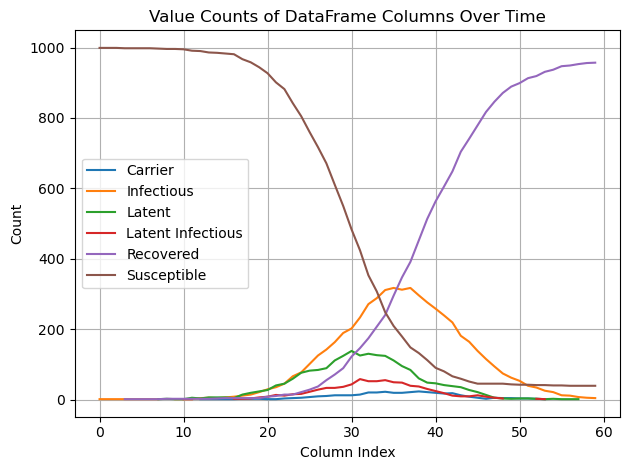

In [49]:
d = {"LI": "Latent Infectious", "L": "Latent", "R": "Recovered", "I": "Infectious", "IS" : "Infectious", "C": "Carrier", "S": "Susceptible"}
infection_counts_df = infection_counts_df.replace(d)
infection_counts_df.head()

value_counts = infection_counts_df.apply(pd.value_counts)

# Plot each row as a separate line
for index, row in value_counts.iterrows():
    plt.plot(row.index, row, label=f"{index}")

# Add labels and title
plt.xlabel('Column Index')
plt.ylabel('Count')
plt.title('Value Counts of DataFrame Columns Over Time')
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
#df.to_excel("MathModeling.xlsx", index=False)

In [35]:
l = []
for i in range(size_of_model):
    got_infected = False
    for j in range(60):
        if infection_counts_df.iloc[i,j] != 'Susceptible':
            got_infected = True
    if got_infected == False:
        l.append(i)

In [36]:
infection_counts_df.iloc[0,0]

'Susceptible'

In [47]:
total = 0
l2  = []
for item in l:
    l2.append(df.iloc[item]["Daily_Contacts_Size"])
np.mean(l2)

12.342857142857143